--- 1. Setting up Environment ---
Tue Oct 28 20:12:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------

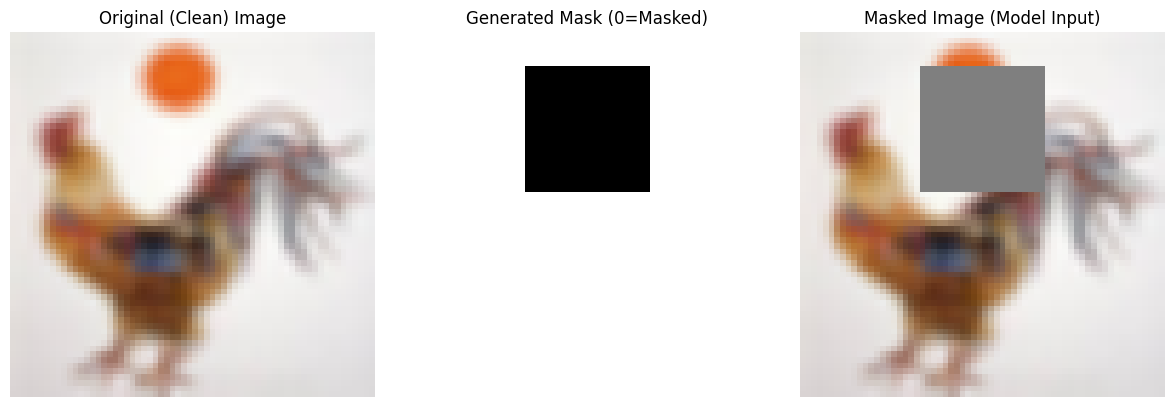

NameError: name 'self' is not defined

In [ ]:
# 1. Check for GPU and install required libraries
print("--- 1. Setting up Environment ---")
!nvidia-smi
!pip install -qq torch torchvision torchaudio Pillow
!pip install -qq datasets transformers accelerate diffusers matplotlib

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print("\n--- Setup complete. Libraries loaded. ---")

# --- 2. Configuration and Custom Dataset ---

# --- CONFIGURATION ---
DATASET_NAME = "cifar10" # Placeholder for a small dataset (easy to download/test)
IMAGE_SIZE = 64 # Images will be resized to 64x64
BATCH_SIZE = 16
MAX_MASK_FRACTION = 0.35 # Max length of the square mask side as a fraction of IMAGE_SIZE
# ---------------------


class InpaintingDataset(Dataset):
    """
    Handles data acquisition, cleaning/pre-processing, and on-the-fly mask generation.
    """
    def __init__(self, dataset_name, image_size):
        # Data Acquisition
        print(f"\nLoading dataset: {dataset_name}...")
        self.data = load_dataset(dataset_name, split="train")

        # Data Pre-processing (Cleaning/Pre-processing)
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(), # Convert PIL Image to Tensor (C, H, W)
            # Normalize to the range [-1, 1], common for diffusion models
            T.Normalize([0.5], [0.5])
        ])

        self.image_size = image_size
        # The maximum pixel length for the mask side
        self.max_mask_length = int(image_size * MAX_MASK_FRACTION)

    def __len__(self):
        return len(self.data)

    def generate_random_square_mask(self):
        """
        Implements the random square mask generation logic.
        Mask values: 0.0 (masked/inpainted region), 1.0 (kept region).
        """
        mask = torch.ones(1, self.image_size, self.image_size, dtype=torch.float32)

        # 1. Determine random size of the square mask
        # Size is between 1/4 of the max_mask_length and the max_mask_length
        mask_len = random.randint(self.max_mask_length // 4, self.max_mask_length)

        # 2. Determine random starting position (top-left corner)
        max_start = self.image_size - mask_len
        if max_start <= 0:
            start_x = 0
            start_y = 0
        else:
            start_x = random.randint(0, max_start)
            start_y = random.randint(0, max_start)

        # 3. Apply the mask: set the area to 0.0
        # The mask is 0 in the area to be inpainted/filled in.
        mask[:, start_y:start_y + mask_len, start_x:start_x + mask_len] = 0.0

        return mask.repeat(3, 1, 1) # Repeat for 3 color channels (C, H, W)

    def __getitem__(self, idx):
        # 1. Load the original image
        original_image_pil = self.data[idx]['img'].convert("RGB")

        # 2. Apply pre-processing
        clean_image = self.transform(original_image_pil)

        # 3. Generate the mask
        mask = self.generate_random_square_mask()

        # 4. Create the masked image (image * mask)
        masked_image = clean_image * mask

        # Simple/dummy text prompt for basic inpainting model setup
        dummy_text = "A high-quality photo"

        return {
            "clean_image": clean_image,
            "mask": mask,
            "masked_image": masked_image,
            "text": dummy_text
        }
# --- 3. Execution and Verification ---

# Create Dataset and DataLoader
inpainting_dataset = InpaintingDataset(dataset_name=DATASET_NAME, image_size=IMAGE_SIZE)

# Create the PyTorch DataLoader
train_dataloader = DataLoader(
    inpainting_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

print(f"\nTotal images in DataLoader (Estimated): {len(train_dataloader) * BATCH_SIZE}")
print(f"Sample Batch Size: {BATCH_SIZE}")

# Get a sample batch
sample_batch = next(iter(train_dataloader))
print(f"Verification: Batch of Tensors loaded with shapes:")
print(f"  Clean Image: {sample_batch['clean_image'].shape}")
print(f"  Mask:        {sample_batch['mask'].shape}")
print(f"  Masked Image: {sample_batch['masked_image'].shape}")

# --- Visualization ---

# Helper function to convert normalized tensor back to plottable image
def denormalize_and_reformat(tensor):
    # Denormalize from [-1, 1] back to [0, 1] and move C from 0 to 2 (C, H, W) -> (H, W, C)
    return (tensor.transpose(1, 2, 0) * 0.5 + 0.5).clip(0, 1)

# Get the first sample from the batch
img = sample_batch['clean_image'][0].numpy()
masked_img = sample_batch['masked_image'][0].numpy()
mask = sample_batch['mask'][0].numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original (Clean) Image")
plt.imshow(denormalize_and_reformat(img))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Mask (0=Masked)")
# Display the mask (only need one channel for grayscale)
plt.imshow(mask[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Masked Image (Model Input)")
plt.imshow(denormalize_and_reformat(masked_img))
plt.axis('off')

plt.tight_layout()
plt.show()